This script provide a demo of results from paper doi: https://doi.org/10.1101/2023.10.30.564663

This demo contains folling steps:
1. Extract the pyoverdine synthesis gene from the antismash result
2. Use hmmer3 to correct the synthesis gene annotation
3. Use NRPSMotifFinder annotated the motif structure of NRPS
4. Deduplication of genome
5. Prediction of pyoverdine product

In [1]:
# import packet
import os
import re
import sys
import glob
import itertools
import subprocess
import multiprocessing
import pickle
import scipy
import matlab.engine
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hcluster
from fnmatch import fnmatch
from sklearn.metrics import silhouette_score
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

matlab_eng = matlab.engine.start_matlab()

# Define variables
hmmheader = ['target name','t accession','tlen','query name','q accession','qlen','E-value','full score','full bias','#','of','c-Evalue','i-Evalue','domain score','domain bias','hmm from','hmm to','ali from','ali to','env from','env to','acc','description of target']
NRPS_domains = ['Condensation', 'AMP-binding', 'PP-binding', 'Thioesterase']

#change path
path = r"Data/pyoverdine_annotation/antiSMASH"
fna_path = r"Data/pyoverdine_annotation/Genome"

In [2]:
# import shutil
# import random

# namelist = [name for name in sp_with_flus if name in sp_with_sythes]
# choose = random.sample(namelist, 20)
# for name in choose:
# 	filename = os.path.join('/storage/disk2/SYZ/data/Mix/antiSMASH/', name)
# 	#拷贝到mix中
# 	filename2 = os.path.join('Data/pyoverdine_annotation/antiSMASH', name)
# 	shutil.copytree(filename, filename2)

# 	name = name + '.fna'
# 	filename = os.path.join('/storage/disk2/SYZ/data/Mix/Genome/', name)
# 	#拷贝到mix中
# 	filename2 = os.path.join('Data/pyoverdine_annotation/Genome', name)
# 	shutil.copyfile(filename, filename2)

In [3]:
#define colormap
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [4]:
# Custom Classes and functions
class SPECIES():
    def __init__(self, name, regionlist):
        self.name = name
        self.regionlist = regionlist
        domainnum = 0
        cdsnum = 0
        if regionlist:
            for region in regionlist:
                domainnum+=len(region.domainlist)
                cdsnum+=len(region.cdslist)
        self.domainnum = domainnum
        self.cdsnum = cdsnum
        if os.path.exists(os.path.join(fna_path, name)+'.fna'):
            self.fasta = list(SeqIO.parse(os.path.join(fna_path, name)+'.fna', "fasta"))
        self.pyoverdine = None
        self.pyoverdine_cds = None
        self.pyoverdine_aa = None
        self.pyoverdine_domain = None
        self.motif_dic = None

class REGION():
    def __init__(self, region_num, location, description, info, cores, allcds, cdslist, domainlist, dic_cds_domain, filename):
        self.region_num = region_num
        self.location = location
        self.description = description
        self.info = info
        self.allcds = allcds
        self.cdslist = cdslist
        self.cores = cores
        self.domainlist = domainlist
        self.dic_cds_domain = dic_cds_domain
        self.filename = filename
        self.knownclusterblast = None
        self.blast_result = None
        self.core_cds = None

#Reading gbk file from antismash result, return a region class
def readgbk(file):
    for seq_record in SeqIO.parse(file, "genbank"):
        domainlist = [feature for feature in seq_record.features if feature.type=='aSDomain']
        allcds = [feature for feature in seq_record.features if feature.type=='CDS']
        cdslist = [cds for cds in allcds if 'NRPS_PKS' in cds.qualifiers]
        dic_cds_domain={}
        for cds in cdslist:
            domainidlist=[re.findall(r"aSDomain: (.+?)$",NRPS_PKS_str)[0] for NRPS_PKS_str in cds.qualifiers['NRPS_PKS'][0:-1]]
            dic_cds_domain[cds]=[domain for domain in domainlist if domain.qualifiers['domain_id'][0] in domainidlist]
        region = [feature for feature in seq_record.features if feature.type=='region'][0]
        location = (seq_record.annotations['structured_comment']['antiSMASH-Data']['Orig. start'], seq_record.annotations['structured_comment']['antiSMASH-Data']['Orig. end'])
        region_num = region.qualifiers['region_number']
        description = seq_record.description
        cores = [feature for feature in seq_record.features if feature.type=='proto_core']

        result = REGION(region_num, location, description, region, cores, allcds, cdslist, domainlist, dic_cds_domain, file.split('/')[-1])
        return result

class safesub(dict):
    def __missing__(self, key):
        return '{' + key + '}'

def sub(text):
    return text.format_map(safesub(sys._getframe(1).f_locals))

STEP 1 Extract the pyoverdine synthesis gene from the antismash result

In [5]:
dirs = [name for name in os.listdir(path)]

splist=[]
i = 0
for folder in dirs:
    i+=1
    floderpath = os.path.join(path, folder)
    gbkfiles = [name for name in os.listdir(floderpath) if fnmatch(name, '*region*.gbk')]
    regionlist=[]
    
    for ind, file in enumerate(gbkfiles):

        filepath = os.path.join(floderpath, file)
        print(sub('--{i}  {folder}  {file} .......'),end='\r')
        #读取一个region的gbk
        temp_result = readgbk(filepath)
        regionlist.append(temp_result)
    specie=SPECIES(folder,regionlist)
    splist.append(specie)

In [6]:
#Form dictionary structure for regiom information
domain_names = pd.read_excel('Data/Antismash_domainnames.xlsx',na_values='').fillna('NAN')[['domainname','domainname_short']].set_index('domainname').T.to_dict('list')

get_domain_sp_name = {}
sp_name_to_sp = {}

domain_id_to_feature = {}
domain_feature_to_record = {}
domain_id_to_name = {}
domain_id_to_name['-'] = '-'
domain_to_cds = {}
cds_to_region = {}
region_to_sp = {}
alldomain = []

for i, sp in enumerate(splist):
    name = sp.name
    print(sub('--{i}  {name}'),end='\r')
    blastfloder = os.path.join(path, sp.name, 'knownclusterblast')
    for ind, region in enumerate(sp.regionlist):

        blast_filename = region.filename.rsplit('.',1)[0]
        blast_filename = blast_filename.rsplit('.',1)[0] + '_c' + str(int(blast_filename.rsplit('.',1)[1].split('region')[1])) + '.txt'
        blast_txt = open(os.path.join(blastfloder, blast_filename))
        lines = blast_txt.readlines()
        pos=lines.index('Significant hits: \n')
        knownclusterblast = re.findall(r"\t(.+?)$",lines[pos+1])
        if knownclusterblast:
            region.knownclusterblast = knownclusterblast[0]
            start_pos = lines.index('Table of Blast hits (query gene, subject gene, %identity, blast score, %coverage, e-value):\n')+1
            if len([index for index, line in enumerate(lines) if line == '>>\n']) == 1:
                end_pos = len(lines)-1
            else:
                end_pos = [index for index, line in enumerate(lines) if line == '>>\n'][1]-3
            blast_result = pd.DataFrame([line.split('\t') for line in lines[start_pos:end_pos]], columns = ['query gene', 'subject gene', '%identity', 'blast score', '%coverage', 'e-value'])
            region.blast_result = blast_result.replace('\n','',regex=True)
            blast_txt.close()

        core_cds = {}
        for core in region.cores:
            loc = (int(core.location.start), int(core.location.end))
            core_cds_list = []
            cds_in_core = [cds for cds in region.allcds if (int(cds.location.start)>=loc[0] and int(cds.location.end<=loc[1]))]
            for cds in cds_in_core:
                if 'gene_kind' in cds.qualifiers and cds.qualifiers['gene_kind'][0]=='biosynthetic':
                    core_cds_list.append(cds)
                    if cds in region.cdslist:
                        for domain in region.dic_cds_domain[cds]:
                            domainname = domain_names[domain.qualifiers['aSDomain'][0]][0]
                            domainrecord = SeqRecord(Seq(domain.qualifiers['translation'][0]), id=sp.name+'__'+domain.qualifiers['domain_id'][0], name=domainname, description=sub('{domainname} domain'))
                            alldomain.append(domainrecord)
                            get_domain_sp_name[domainrecord.id] = sp.name
                            domain_id_to_name[domainrecord.id] = domainname
                            domain_id_to_feature[domainrecord.id] = domain
                            domain_feature_to_record[domain] = domainrecord
                            domain_to_cds[domain] = cds
                cds_to_region[cds] = region
            core_cds[core] = core_cds_list
        region.core_cds = core_cds
        region_to_sp[region] = sp
    sp_name_to_sp[sp.name] = sp

In [7]:
#extract pyoverdine sequence based on rules (detail in paper)
gene_kind_list = ['biosynthetic', 'biosynthetic-additional', 'other']
    
normal_pyoverdine = []
entir_pyoverdine = []
clip_pyoverdine = []
island_to_region = {}

temp_dic = {}

for sp in splist:
    cdss = {}
    for region in [region for region in sp.regionlist if region.knownclusterblast=='pyoverdin']:
        for core in [core for core in region.cores if core.qualifiers['product'][0]=='NRPS']:
            loc = (int(core.location.start), int(core.location.end))
            cds_in_core = [cds for cds in region.allcds if (int(cds.location.start)>=loc[0] and int(cds.location.end<=loc[1]))]
            for cds in region.core_cds[core]:
                if cds.qualifiers['locus_tag'][0] in list(region.blast_result['query gene']):
                    break
            else:
                continue

            if region.core_cds[core] == cds_in_core:
                normal_pyoverdine.append(sp)
                core.strand = np.sign(sum([cds.strand*len(cds) for cds in cds_in_core]))
                island_to_region[core] = region
                cdss[core] = region.core_cds[core]
                temp_dic[core] = region
                continue
            for cds in cds_in_core:
                if 'gene_kind' in cds.qualifiers and (cds.qualifiers['gene_kind'][0] not in gene_kind_list):
                    break
                if len(cds)>1200 and cds not in region.core_cds[core]:
                    break
            else:
                entir_pyoverdine.append(sp)
                core.strand = np.sign(sum([cds.strand*len(cds) for cds in cds_in_core]))
                island_to_region[core] = region
                cdss[core] = region.core_cds[core]
                temp_dic[core] = region
                continue

            clip_pyoverdine.append(sp)
            groups = itertools.groupby(cds_in_core, lambda x: x in region.core_cds[core])
            cor_part = [featurelist for featurelist in [list(g) for k, g in groups] if featurelist[0] in region.core_cds[core]]
            for island in cor_part:
                island_loc = (int(island[0].location.start), int(island[-1].location.end))
                for cds in island:
                    if cds.qualifiers['locus_tag'][0] in list(region.blast_result['query gene']) or (len(cds)>3000 and len(cds)<10000):
                        break
                else:
                    continue
                island_feature = SeqFeature(FeatureLocation(island_loc[0], island_loc[1], strand = np.sign(sum([cds.strand*len(cds) for cds in island]))), type = "island")
                island_to_region[island_feature] = region
                cdss[island_feature] = island
                temp_dic[island_feature] = region
    sp.pyoverdine_cds = cdss

print('strain with pyoverdine fragments')
print(len([sp for sp in splist if sp.pyoverdine_cds]))

strain with pyoverdine fragments
37


In [8]:
#Find CAL and TE domain
sp_with_CAL = []
sp_with_TE = []

for sp in [sp for sp in splist if sp.pyoverdine_cds]:
    for island in sp.pyoverdine_cds:
        island.qualifiers['marker'] = []
        for cds in sp.pyoverdine_cds[island]:
            if cds in cds_to_region[cds].dic_cds_domain:
                for domain in cds_to_region[cds].dic_cds_domain[cds]:
                    if domain.qualifiers['aSDomain'][0] == 'CAL_domain':
                        island.qualifiers['marker'].append('CAL')
                        sp_with_CAL.append(sp)
                    if domain.qualifiers['aSDomain'][0] == 'Thioesterase':
                        island.qualifiers['marker'].append('TE')
                        sp_with_TE.append(sp)

In [9]:
#Assemble pyoverdine sequence

suited_sp = []
for sp in [sp for sp in splist if sp.pyoverdine_cds]:
    CALnum = sum([island.qualifiers['marker'].count('CAL') for island in sp.pyoverdine_cds])
    TEnum = sum([island.qualifiers['marker'].count('TE') for island in sp.pyoverdine_cds])
    if CALnum<=1 and TEnum<=1:
        if len(sp.pyoverdine_cds) == 1:
            suited_sp.append(sp)
        if len(sp.pyoverdine_cds) == 2:
            if sp in sp_with_CAL or sp in sp_with_TE:
                suited_sp.append(sp)
        if len(sp.pyoverdine_cds) == 3:
            if sp in sp_with_CAL and sp in sp_with_TE:
                suited_sp.append(sp)

def get_marker(island):
    if 'CAL' in island.qualifiers['marker']:
        return -1
    elif 'TE' in island.qualifiers['marker']:
        return 1
    else:
        return 0

for i, sp in enumerate(suited_sp):
    name = sp.name
    print(sub('--{i}  {name}'),end='\r')
    pyoverdin_seq = []
    sort_island = sorted(sp.pyoverdine_cds, key = get_marker)
    for island in sort_island:
        region = island_to_region[island]
        try:
            fasta = [fasta for fasta in sp.fasta if re.findall(r"\|(.*)\|",region.description)[0] in fasta.id][0]
        except IndexError:
            fasta = [fasta for fasta in sp.fasta if region.description in fasta.id][0]
            print(name)
        fasta = fasta[int(region.location[0]):int(region.location[1])]
        
        direction = island.strand
        if abs(sum([cds.strand for cds in sp.pyoverdine_cds[island]])) != len(sp.pyoverdine_cds[island]):
            for cds in sp.pyoverdine_cds[island]:
                try:
                    for domain in region.dic_cds_domain[cds]:
                        if domain.qualifiers['aSDomain'][0] == 'Thioesterase':
                            direction = -cds.strand
                except KeyError:
                    continue
            if direction == 1:
                sub_island = [cds for cds in sp.pyoverdine_cds[island] if cds.strand == direction]
                pyoverdin_seq.append(fasta[int(sub_island[0].location.start): int(sub_island[-1].location.end)])
                sub_island = [cds for cds in sp.pyoverdine_cds[island] if cds.strand == -direction]
                pyoverdin_seq.append(fasta[int(sub_island[0].location.start): int(sub_island[-1].location.end)].reverse_complement())
            else:
                sub_island = [cds for cds in sp.pyoverdine_cds[island] if cds.strand == direction]
                pyoverdin_seq.append(fasta[int(sub_island[0].location.start): int(sub_island[-1].location.end)].reverse_complement())
                sub_island = [cds for cds in sp.pyoverdine_cds[island] if cds.strand == -direction]
                pyoverdin_seq.append(fasta[int(sub_island[0].location.start): int(sub_island[-1].location.end)])
        else:
            if direction == 1:
                pyoverdin_seq.append(fasta[int(island.location.start):int(island.location.end)])
            else:
                pyoverdin_seq.append(fasta[int(island.location.start):int(island.location.end)].reverse_complement())
    
    #将核苷酸序列合并，并写出为gbk
    seq = SeqRecord(Seq(''))
    for record in pyoverdin_seq:
        seq = seq + record
    seq.features.append(SeqFeature(FeatureLocation(start=0, end=len(seq)), type='gene'))
    seq.features.append(SeqFeature(FeatureLocation(start=0, end=len(seq)), type='CDS'))
    seq.annotations['molecule_type'] = 'DNA'
    seq.id = sub('{name}')
    seq.description = 'pyoverdine nt'
    sp.pyoverdine = seq

2. Use hmmer3 to correct the synthesis gene annotation (Fragment shift)

In [10]:
#use six-frame to correct fragment shift
candidate_orf = []
for i, sp in enumerate(suited_sp):
    sequence = sp.pyoverdine.seq
    name = sp.name
    for ini_position in [0,1,2]:
        candidate_orf.append(SeqRecord(sequence[ini_position:].translate(table = 11), id = sub('{name}_{ini_position}')))

SeqIO.write(candidate_orf, "temp/candidate_orf.fasta", "fasta")

FNULL = open(os.devnull, 'w')
subprocess.run(sub('bash -c "source activate hmmer3; hmmscan --domtblout temp/six_frame.dom --notextw --noali -E 1e-5 --domE 1e-5 Data/Pfam-A.hmm temp/candidate_orf.fasta"'), shell=True, stdout=FNULL)

#remove head and tail
lines = []
with open("temp/six_frame.dom", 'r') as fp:
    lines = fp.readlines()

with open("temp/six_frame.txt", 'w') as fp:
    for line in lines[3:-10]:
        fp.write(line)

hmmer_raw = pd.read_csv('temp/six_frame.txt',sep='\s+', header = None, names=hmmheader, index_col=False, engine='python')
hmmer_result = hmmer_raw.astype({"query name": str})

for i, sp in enumerate(suited_sp):
    name = sp.name
    sequence = sp.pyoverdine.seq
    print(sub('--{i}  {name}'),end='\r')
    ze = np.zeros((3, int(len(sequence)/3)))
    for i in [0,1,2]:
        subl = hmmer_result[hmmer_result['query name']==sub('{name}_{i}')]
        subl = subl[subl['target name'].isin(NRPS_domains)]
        if subl.empty:
            continue
        for index, rows in subl.iterrows():
            ze[i,rows['env from']:rows['env to']] = 1

    AA = SeqRecord(Seq(''))
    i = 0
    change = 0
    for j in range(np.shape(ze)[1]):
        if ze[i,j]==1:
            codon = sequence[i+j*3:i+(j+1)*3]
            AA = AA + codon.translate(table = 11)
        elif sum(ze[:,j])==0:
            codon = sequence[i+j*3:i+(j+1)*3]
            AA = AA + codon.translate(table = 11)
        else:
            change += 1
            other_frame = [0,1,2]
            other_frame.remove(i)
            if ze[other_frame[0],j] != 0:
                i = other_frame[0]
                codon = sequence[i+j*3:i+(j+1)*3]
                AA = AA + codon.translate(table = 11)
            else:
                i = other_frame[1]
                codon = sequence[i+j*3:i+(j+1)*3]
                AA = AA + codon.translate(table = 11)
    AA.id = sub('{name}')
    AA.description = 'pyoverdine aa'
    sp.pyoverdine_aa = AA

/home/zhiyuanlab/miniconda3/envs/HG_default/lib/python3.8/site-packages/Bio/Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


/tmp/ipykernel_3673928/2404186159.py:23: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hmmer_raw = pd.read_csv('temp/six_frame.txt',sep='\s+', header = None, names=hmmheader, index_col=False, engine='python')


3. Use NRPSMotifFinder annotated the motif structure of NRPS

In [11]:
# annotated refrence sequence
A_substrates = pd.read_excel('Data/substrate_230302.xlsx',header=0)
New_sps = []
sp_name_to_sp_new = {}
for i, spname in enumerate(A_substrates['spname']):
    if spname in sp_name_to_sp:
        continue
    elif spname in [sp.name for sp in New_sps]:
        sp = sp_name_to_sp_new[spname]
        sp.pyoverdine_aa = SeqRecord(sp.pyoverdine_aa.seq + Seq(A_substrates.loc[i]['Aseq']), id = spname)
    else:
        new_sp = SPECIES(spname, None)
        new_sp.pyoverdine_aa = SeqRecord(Seq(A_substrates.loc[i]['Aseq']), id = spname)
        New_sps.append(new_sp)
        sp_name_to_sp_new[spname] = new_sp

def Codetransform_HRL(align_seq,code):
	gap_site = [i+1 for i, char in enumerate(align_seq) if char == '-']
	try:
		code_align = np.zeros((len(code),1))
	except TypeError:
		code = np.array([code])
		code_align = np.zeros((len(code),1))
	for i in range(len(code)):
		new = code[i] + len([a for a in gap_site if a <=code[i]])
		old = code[i]
		while len([a for a in gap_site if a <=old]) != len([a for a in gap_site if a <=new]):
			old = new
			new = code[i] + sum(gap_site<=new)
		code_align[i] = new
	return(code_align)
	
def find_motif(seq, ref_seq, motif_list, list_sorted, i_, recordid, seqstart):
	query = SeqRecord(seq, id='query')
	refrence = SeqRecord(Seq(ref_seq), id='targrt')

	SeqIO.write([query, refrence], sub("temp/{recordid}.fasta"), "fasta")
	subprocess.run(sub('clustalo -i temp/{recordid}.fasta -o temp/{recordid}_aln.fasta --force'), shell=True)
	loc_seq_MSA = [seq for seq in SeqIO.parse(sub("temp/{recordid}_aln.fasta"), "fasta")]

	# ref_start = min([i for i, char in enumerate(loc_seq_MSA[1].seq) if char != '-'])
	loc_motif_list=[]
	gap_list = [i+1 for i, char in enumerate(loc_seq_MSA[0].seq) if char == '-']

	for j in range(len(motif_list)):
		# 注意参考是matlab坐标
		loc_start = Codetransform_HRL(loc_seq_MSA[1].seq, motif_list[j, 0])
		loc_end = Codetransform_HRL(loc_seq_MSA[1].seq, motif_list[j, 1])
		loc_start2 = loc_start - len([a for a in gap_list if a < loc_start]) + seqstart
		loc_end2 = loc_end - len([a for a in gap_list if a < loc_end]) + seqstart
		if i_ == len(list_sorted)-1:
			compared_end = len(seq)
		else:
			compared_end = list_sorted.loc[i_+1]['start']
		if (int(loc_start) <= -1) or (int(loc_start2) == int(loc_end2)) or (int(loc_end2) >= compared_end):
			loc_motif_list.append([np.array([[np.nan]]), np.array([[np.nan]])])
		else:
			loc_motif_list.append([loc_start2, loc_end2])
	return(loc_motif_list)

NRPS_domains = ['Condensation', 'AMP-binding','PP-binding', 'Thioesterase']
AA_leter = 'ACDEFGHIKLMNPQRSTVWYX'

mat_file = sio.loadmat('Data/matlab230206.mat')
A_refer_seq = mat_file['A_refer_seq']['Sequence'][0][0][0]
A_motif_list = mat_file['A_motif_list']
A_motif_name = ['alpha',1,2,3,4,5,6,'G',7,8,9,10]
T_refer_seq = mat_file['T_refer_seq']['Sequence'][0][0][0]
T_motif_list = mat_file['T_motif_list']
T_motif_name = ['alpha',1]
TE_refer_seq = mat_file['TE_refer_seq']['Sequence'][0][0][0]
TE_motif_list = mat_file['TE_motif_list']
TE_motif_name = list(range(1,len(TE_motif_list)+1))

referCE_dtype_str = ['LCL','SgcC5','DCL','Starter','Cyc','Dual','Cglyc','Hybrid','modAA','CT','CT-DCL','CT-LCL','FUM14','It','I','bL','PS','X','E']
referCE_motif_list = [mat_file['referCE_motif_list'][i][0] for i in range(len(mat_file['referCE_motif_list']))]
referCE_seq = [mat_file['referCE_seq'][i][0][0][0][1][0] for i in range(len(mat_file['referCE_seq']))]

C_motif_dict = dict(zip(referCE_dtype_str,referCE_motif_list))
C_ref_seq_dict = dict(zip(referCE_dtype_str,referCE_seq))
C_motif_name_dict = dict(zip(referCE_dtype_str,[list(range(1,len(v)+1)) for v in C_motif_dict.values()]))


all_motif_list = {
	'AMP-binding':A_motif_list,
	'PP-binding':T_motif_list,
	'Thioesterase':TE_motif_list,
}
all_motif_list.update(C_motif_dict)

all_ref_seq = {
	'AMP-binding':A_refer_seq,
	'PP-binding':T_refer_seq,
	'Thioesterase':TE_refer_seq,
}
all_ref_seq.update(C_ref_seq_dict)

all_motif_name = {
	'AMP-binding':A_motif_name,
	'PP-binding':T_motif_name,
	'Thioesterase':TE_motif_name,
}
all_motif_name.update(C_motif_name_dict)

manager = multiprocessing.Manager()
Result = manager.dict()

seqrecords = [sp.pyoverdine_aa for sp in suited_sp + New_sps]

for seqrecord in seqrecords:
    if set(seqrecord) - set(AA_leter):
        seq = str(seqrecord.seq)
        for letter in (set(seqrecord) - set(AA_leter)):
            seq = seq.replace(letter, 'X')
        seqrecord.seq = Seq(seq)

#hmm scan by pfam
SeqIO.write(seqrecords, "temp/pyoverdine_aa.fasta", "fasta")

subprocess.run(sub('bash -c "source activate hmmer3; hmmscan --domtblout temp/pyoverdine_aa.dom --notextw --noali -E 1e-5 --domE 1e-5 Data/Pfam-A.hmm temp/pyoverdine_aa.fasta"'), shell=True, stdout=FNULL)

#remove head and tail
lines = []
with open("temp/pyoverdine_aa.dom", 'r') as fp:
    lines = fp.readlines()

with open("temp/pyoverdine_aa.txt", 'w') as fp:
    for line in lines[3:-10]:
        fp.write(' '.join(re.split("\s+", line)[0:23]) + '\n')

hmmer_raw = pd.read_csv('temp/pyoverdine_aa.txt',sep='\s+', header = None, names=hmmheader, index_col=False)
hmmer_raw = hmmer_raw.astype({"query name": str})

for seqrecord in seqrecords:
	region = hmmer_raw[hmmer_raw['query name'] == seqrecord.id]

	hmmer_Other_result = region[region['target name'].isin(
		[name for name in NRPS_domains if name != 'Thioesterase'])]
	hmmer_TE_result = region[region['target name'] == 'Thioesterase']
	TE_over = hmmer_TE_result[hmmer_TE_result['hmm to'] -
								hmmer_TE_result['hmm from'] > hmmer_TE_result['tlen']*0.5]
	TE_under = hmmer_TE_result[hmmer_TE_result['hmm to'] -
								hmmer_TE_result['hmm from'] <= hmmer_TE_result['tlen']*0.5]
	Other_over = hmmer_Other_result[hmmer_Other_result['hmm to'] -
									hmmer_Other_result['hmm from'] > hmmer_Other_result['tlen']*0.6]
	Other_under = hmmer_Other_result[hmmer_Other_result['hmm to'] -
										hmmer_Other_result['hmm from'] <= hmmer_Other_result['tlen']*0.6]

	true_region = pd.concat([Other_over, TE_over])
	pesu_region = pd.concat([Other_under, TE_under])

	start_list = np.array(true_region['env from'])
	end_list = np.array(true_region['env to'])
	domain_list = np.array(true_region['target name'])
	pesu_domain_list = pesu_region['target name']
	
	# process the problem because hmmer3 sometime will spilt one domain to two same type domains.
	for domainname in pesu_domain_list.unique():
		hmm_domain = pesu_region[pesu_region['target name'] == domainname]
		if len(hmm_domain) > 0:
			remove_list = []
			domain_length = hmm_domain['tlen'].iloc[0]
			for index1, rows1 in hmm_domain.iterrows():
				if index1 not in remove_list:
					for index2, rows2 in hmm_domain.iterrows():
						if (index2 not in remove_list) and (index1 != index2):
							start1 = hmm_domain.loc[index1, 'env from']
							start2 = hmm_domain.loc[index2, 'env from']
							end1 = hmm_domain.loc[index1, 'env to']
							end2 = hmm_domain.loc[index2, 'env to']
							# if overlap or gap <50% domain length
							if (start1 <= start2 and start2 <= end1) or (start1 <= end2 and end2 <= end1) or (end2 <= start1 and ((start1-end2) < 0.5*domain_length)) or (start2 >= end1 and ((start2-end1) < 0.5*domain_length)):
								new_start = min([start1, start2])
								new_end = max([end1, end2])
							else:
								remove_list.append(index1)
								remove_list.append(index2)
								continue
							# merge two picies, looking for more
							if (not (np.logical_and(start_list > new_start, start_list < new_end).any())) and (not (np.logical_and(end_list > new_start, end_list < new_end).any())) and ((new_end-new_start+1) > 0.6*domain_length):
								domain_list = np.append(
									domain_list, pesu_domain_list.loc[index1])
								start_list = np.append(start_list, new_start)
								end_list = np.append(end_list, new_end)
								remove_list.append(index1)
								remove_list.append(index2)
								break

	#sort by order
	list_sorted = pd.DataFrame(np.array(
		[start_list, end_list, domain_list]).T, columns=['start', 'end', 'domain'])
	list_sorted = list_sorted.sort_values(by=['start'])

	list_sorted = list_sorted.reset_index(drop=True)
	list_sorted.loc[-1] = [np.nan, 1, "START"]  # adding a row
	list_sorted.index = list_sorted.index + 1  # shifting index
	list_sorted.loc[len(list_sorted)] = [len(seqrecord), np.nan, "END"]
	list_sorted = list_sorted.sort_index()

	#find motif by reference sequence
	result_table = pd.DataFrame(columns=['start','end','domain','motif', 'motif name'])
	for i in range(len(list_sorted)):
		if i == 0 or i == len(list_sorted)-1:
			continue
		else:
			domain_name = list_sorted.loc[i]['domain']
			# C this start - next start
			if domain_name == 'Condensation':
				start = list_sorted.loc[i]['start']
				end = list_sorted.loc[i+1]['start']
			# A last end - next start
			elif domain_name == 'AMP-binding':
				start = list_sorted.loc[i-1]['end']
				end = list_sorted.loc[i+1]['start']
			#T last end - this end
			elif domain_name == 'PP-binding':
				start = list_sorted.loc[i-1]['end']
				end = list_sorted.loc[i]['end']
			# TE T this
			else:
				start = list_sorted.loc[i]['start']
				end = list_sorted.loc[i]['end']

		#given seq and domain type, identity motif
		seq=seqrecord[start-1:end].seq

		if domain_name == 'Condensation':
			SeqIO.write(SeqRecord(seq,id = 'temp_C'), "temp/temp_C.fasta", "fasta")
			subprocess.run(sub('bash -c "source activate hmmer3; hmmscan --domtblout temp/temp_C.dom --notextw --noali -E 1e-5 --domE 1e-5 /home/SYZ/HRL/C_model.hmm  temp/temp_C.fasta"'), shell=True, stdout=FNULL)
			#remove head and tail
			lines = []
			with open("temp/temp_C.dom", 'r') as fp:
				lines = fp.readlines()

			with open("temp/temp_C.txt", 'w') as fp:
				for line in lines[3:-10]:
					fp.write(line)
			hmmer_raw_ = pd.read_csv('temp/temp_C.txt',sep='\s+', header = None, names=hmmheader, index_col=False)
			hmmer_raw_ = hmmer_raw_.astype({"query name": str})

			domain_name = hmmer_raw_.loc[0]['target name']
			list_sorted.loc[i]['domain'] = domain_name

		motifs = find_motif(seq, all_ref_seq[domain_name], all_motif_list[domain_name], list_sorted, i, seqrecord.id, start)
		motifs = np.array(motifs).reshape(-1,2)
		motifs_name = all_motif_name[domain_name]

		#move end to last motif
		if not(np.isnan(motifs[0][0])):
			start = motifs[0][0]

		if not(np.isnan(motifs[-1][0])):
			end = motifs[-1][1]

		result_table.loc[len(result_table.index)] = [start, end, domain_name, motifs, motifs_name]

	Result[seqrecord.id] = result_table

# p_map(parrel_define_domain, seqrecords)

#转换为之前熟悉的形式
domain_di = {'AMP-binding':'A',
		'PP-binding':'T',
		'Thioesterase':'TE'}
for C_domain_name in  referCE_dtype_str:
	domain_di[C_domain_name] = 'C'
domain_di['E'] = 'E'

for sp in tqdm(suited_sp):
	result = Result[sp.name]
	result = result.replace({"domain": domain_di})
	#编号排序
	pre_doamin = 'start'
	domain_pos = {}
	motif_dict = {}
	domains = result['domain']
	domain_num = 0
	#全部matlab坐标，记得转python
	result['start'] = result['start'] - 1
	for index, domainname in enumerate(domains):
		if domainname == 'C':
			if pre_doamin == 'C':
				#2022/11/9 根据文献 确实应该保留第一个C www.pnas.org/doi/10.1073/pnas.1903161116
				continue
			else:
				domain_num += 1
		if (domainname + '_' + str(domain_num) in domains.tolist()) and (domainname != 'C'):
			domain_num += 1 
		domains[index] = domainname + '_' + str(domain_num)
		pre_doamin = domainname
		#全部matlab坐标，记得转python
		domain_pos[domains[index]] = (int(result.loc[index]['start']), int(result.loc[index]['end']))
		a = result.loc[index]['motif']
		a[:,0] = a[:,0]-1
		a = a.astype('float64')
		motif_dict[domains[index]] = dict(zip(result.loc[index]['motif name'], result.loc[index]['motif'] - result.loc[index]['start']))

	sp.motif_dic = motif_dict
	sp.pyoverdine_domain = domain_pos
	sp.domain_motif_df = Result[sp.name]

for sp in tqdm(New_sps):
	result = Result[sp.name]
	result = result.replace({"domain": domain_di})
	#编号排序
	domain_pos = {}
	motif_dict = {}
	domains = result['domain']
	if sp.name == 'Pseudomonas_aeruginosa_PAO1_107':
		domain_num = -1
	else:
		domain_num = 3
	#全部matlab坐标，记得转python
	result['start'] = result['start'] - 1
	for index, domainname in enumerate(domains):
		if domainname == 'A':
			domain_num += 1
		domains[index] = domainname + '_' + str(domain_num)
		#全部matlab坐标，记得转python
		domain_pos[domains[index]] = (result.loc[index]['start'], result.loc[index]['end'])
		a = result.loc[index]['motif']
		a[:,0] = a[:,0]-1
		motif_dict[domains[index]] = dict(zip(result.loc[index]['motif name'], result.loc[index]['motif'] - result.loc[index]['start']))

	sp.motif_dic = motif_dict
	sp.pyoverdine_domain = domain_pos
	sp.domain_motif_df = Result[sp.name]

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_3673928/3360729431.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domains[index] = domainname + '_' + str(domain_num)
/tmp/ipykernel_3673928/3360729431.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domains[index] = domainname + '_' + str(domain_num)
/tmp/ipykernel_3673928/3360729431.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domains[index] = domainname + '_'

4. Deduplication of genome, skip the step of if only pyoverdine prediction

In [12]:
#check truncated synthetic genes
edge_thrd = 100
edge_sp = []
for sp in suited_sp:
	for region in [region for region in sp.regionlist if region.knownclusterblast=='pyoverdin']:
		for core in [core for core in region.cores if core.qualifiers['product'][0]=='NRPS']:
			if int(core.location.start) <=edge_thrd:
				edge_sp.append(sp)
			elif int(region.info.location.end) - int(core.location.end) <=edge_thrd:
				edge_sp.append(sp)
no_edge = [sp for sp in suited_sp if sp not in edge_sp]

#check flu
flus = []
sythes = []

for aln in list(SeqIO.parse('Data/pyoverdine_aa_with_ref_flu.aln', "fasta"))[0:-56]:
    flu = aln[:18693]
    sythe = aln[18693:]
    flus.append(flu)
    sythes.append(sythe)

sp_with_flus = [flu.id for flu in flus if (flu.seq.count('X')/(len(flu.seq.ungap('-'))+1)<0.05 and len(flu.seq.ungap('-'))>4000 and len(flu.seq.ungap('-'))<4700)]
sp_with_sythes = [flu.id for flu in sythes if (flu.seq.count('X')/(len(flu.seq.ungap('-'))+1)<0.2 and flu.seq.count('-')/len(flu.seq)<0.97)]

#计算菌株N50
def calcuN50(sp):
   BaseSum = 0
   Length = []
   ValueSum,n50 = 0,0
   for record in sp.fasta:
      BaseSum += len(record.seq)
      Length.append(len(record.seq))
   N50_pos = BaseSum/2
   Length.sort()
   Length.reverse()
   for value in Length:
      ValueSum += value
      if N50_pos <= ValueSum:
         n50 = value
         return(n50)

In [13]:
#Deduplication
complete_sp = []

for sp in suited_sp:
	if sp not in edge_sp:
		if sp.name in sp_with_flus and sp.name in sp_with_sythes:
			complete_sp.append(sp)

selected_spname_list = [sp_.name for sp_ in complete_sp]

# load pyoverdine distance
print(sub('loading.......'))
filename= 'Data/pyoverdine_aa_fll_length_distance'
f = open(filename, 'rb')
pyoverdine_distance_all = pickle.load(f)
f.close()

pyoverdine_distance_all = pyoverdine_distance_all.stack().reset_index()
pyoverdine_distance_all.columns = ['query','refrence','distance']

pyoverdine_distance_all = pyoverdine_distance_all.drop(pyoverdine_distance_all[pyoverdine_distance_all['query'] == pyoverdine_distance_all['refrence']].index)
pyoverdine_distance_all = pyoverdine_distance_all[pyoverdine_distance_all['refrence'].isin(selected_spname_list) & pyoverdine_distance_all['query'].isin(selected_spname_list)]


mat_file = sio.loadmat('Data/allphy_seqdist.mat')
phy_seqs = [fasta for fasta in SeqIO.parse(sub("Data/Genome_concatenated.aln"), "fasta")]
phy_matrix = pd.DataFrame(mat_file['seqdist_allphy'], index = [seq.id for seq in phy_seqs], columns = [seq.id for seq in phy_seqs])

phy_matrix = phy_matrix.stack().reset_index()
phy_matrix.columns = ['query','refrence','phy_distance']

phy_matrix = phy_matrix.drop(phy_matrix[phy_matrix['query'] == phy_matrix['refrence']].index)
phy_matrix = phy_matrix[phy_matrix['refrence'].isin(selected_spname_list) & phy_matrix['query'].isin(selected_spname_list)]

judge_df = pd.merge(phy_matrix, pyoverdine_distance_all,  how='inner', left_on=['query','refrence'], right_on = ['query','refrence'])

a = judge_df[(judge_df['phy_distance']<0.05) & (judge_df['distance']<0.05)]

dupl = set()
for i in range(len(a)):
    query = a.iat[i,0]
    refrence = a.iat[i,1]
    if query in dupl or refrence in dupl:
        continue
    elif calcuN50(sp_name_to_sp[query]) >= calcuN50(sp_name_to_sp[refrence]):
        dupl.add(refrence)
    else:
        dupl.add(query)

producers = list(set(selected_spname_list) - (dupl))

loading.......


Text(0.5, 0, 'number of A domains per synthetase')

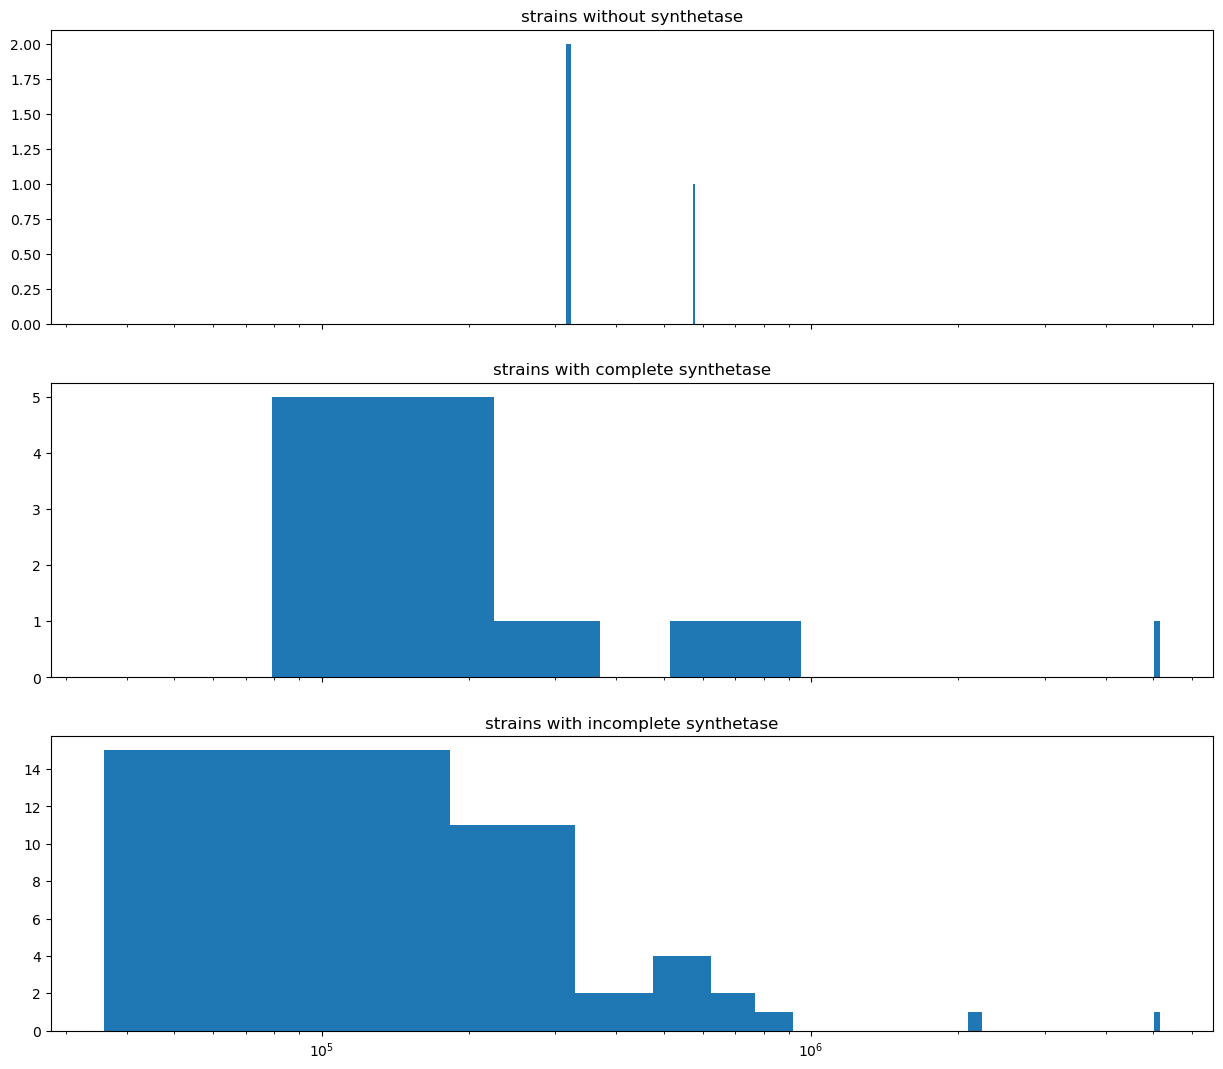

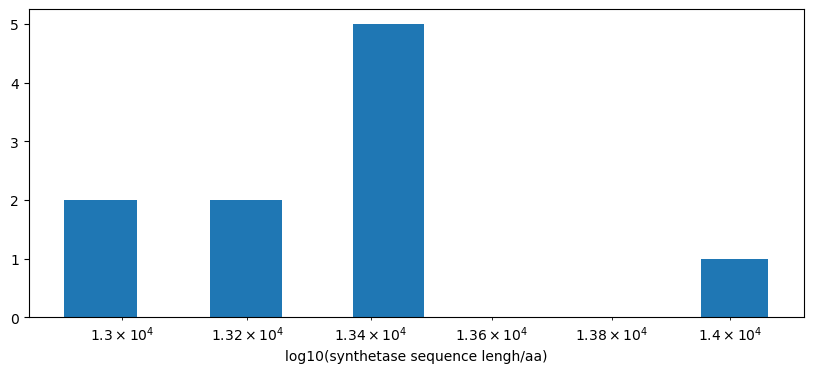

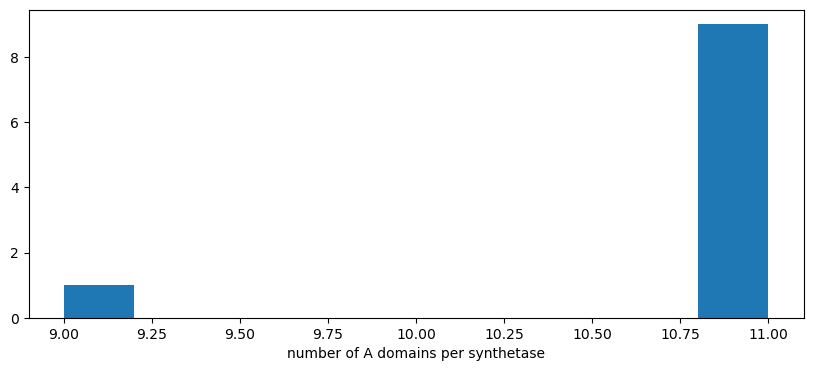

In [14]:
#generated figure
x1 = [calcuN50(sp) for sp in splist if not sp.pyoverdine_cds]
x2 = [calcuN50(sp) for sp in [sp for sp in splist if sp.pyoverdine_cds] if sp not in producers]
x3 = [calcuN50(sp_name_to_sp[sp]) for sp in producers]
fig,axs = plt.subplots(3,1,figsize=(15,13), sharex=True)
axs[0].hist(x1,bins = 35)
axs[0].set_title('strains without synthetase')
axs[1].hist(x3,bins = 35)
axs[1].set_title('strains with complete synthetase')
axs[2].hist(x2,bins = 35)
axs[2].set_title('strains with incomplete synthetase')
plt.xscale('log')

x4 = [len(sp_name_to_sp[sp].pyoverdine_aa) for sp in producers]
x5 = [len([a for a in sp_name_to_sp[sp].pyoverdine_domain.keys() if a[0] == 'A']) for sp in producers]
fig,ax = plt.subplots(figsize=(10,4))
ax.hist(x4,bins = 10)
ax.set_xlabel('log10(synthetase sequence lengh/aa)')
plt.xscale('log')

fig,ax = plt.subplots(figsize=(10,4))
ax.hist(x5,bins = 10)
ax.set_xlabel('number of A domains per synthetase')

5. Prediction of pyoverdine product

In [15]:
#get A45 domain
pyoverdine_set = [sp.name for sp in suited_sp]

colormap = sns.color_palette([
"#ffa3bb",
"#2e8b57",
"#00b9e2",
"#f46283",
"#c78376",
"#008ade",
"#fe8160",
"#bcc0ff",
"#a46a31",
"#ad62c2",
"#e5c04f",
"#98fb98",
"#BFD6D9",
"#9EB7C5",
"#E6F4F1"
])
sub_colordict = dict(zip(A_substrates['substrate'].value_counts().index.tolist(),colormap))
sub_color = pd.Series([sub_colordict[group] for group in A_substrates['substrate']])
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


['Ser' 'Arg' 'OHOrn' 'Lys' 'Thr' 'Orn' 'Gly' 'Rsc' 'Glu' 'Tyr' 'Dab' 'Ala'
 'OHAsp' 'Asp' 'Gln']


[(1.0, 0.6392156862745098, 0.7333333333333333),
 (0.1803921568627451, 0.5450980392156862, 0.3411764705882353),
 (0.0, 0.7254901960784313, 0.8862745098039215),
 (0.9568627450980393, 0.3843137254901961, 0.5137254901960784),
 (0.7803921568627451, 0.5137254901960784, 0.4627450980392157),
 (0.0, 0.5411764705882353, 0.8705882352941177),
 (0.996078431372549, 0.5058823529411764, 0.3764705882352941),
 (0.7372549019607844, 0.7529411764705882, 1.0),
 (0.6431372549019608, 0.41568627450980394, 0.19215686274509805),
 (0.6784313725490196, 0.3843137254901961, 0.7607843137254902),
 (0.8980392156862745, 0.7529411764705882, 0.30980392156862746),
 (0.596078431372549, 0.984313725490196, 0.596078431372549),
 (0.7490196078431373, 0.8392156862745098, 0.8509803921568627),
 (0.6196078431372549, 0.7176470588235294, 0.7725490196078432),
 (0.9019607843137255, 0.9568627450980393, 0.9450980392156862)]

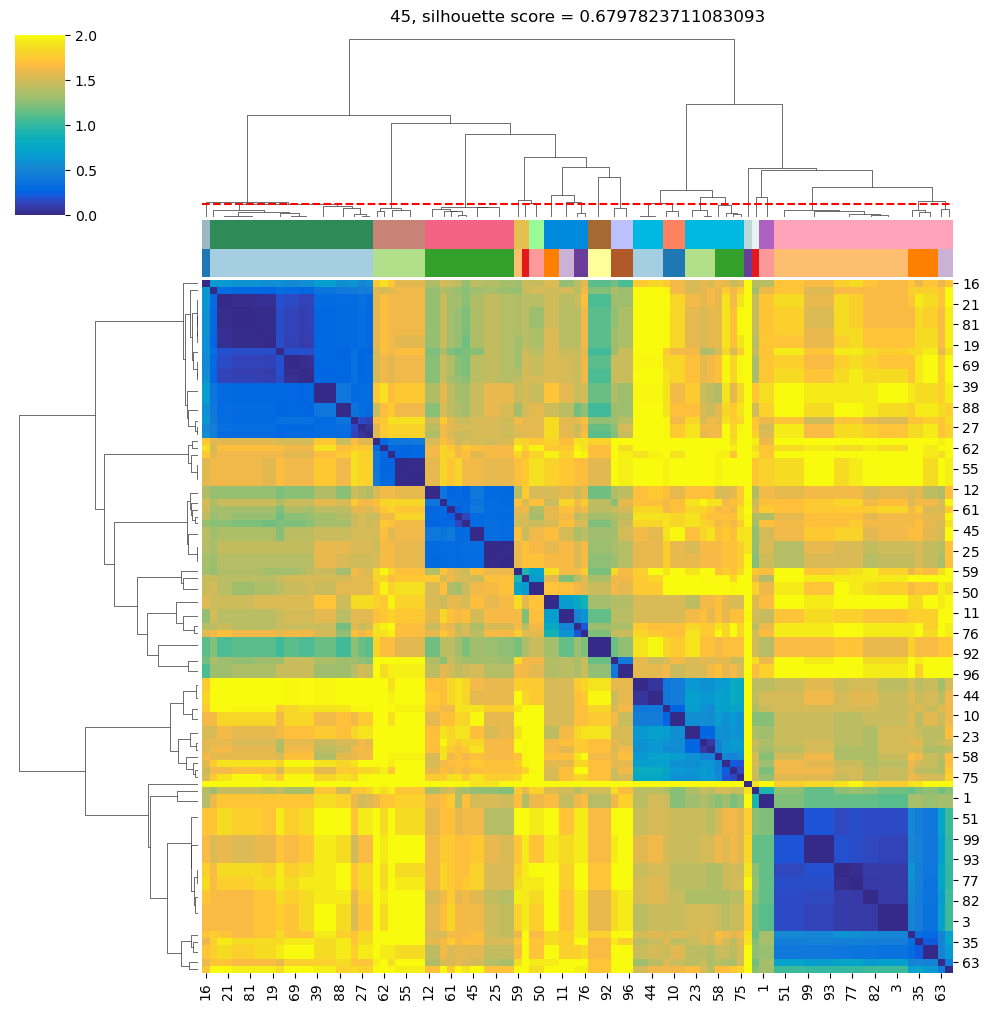

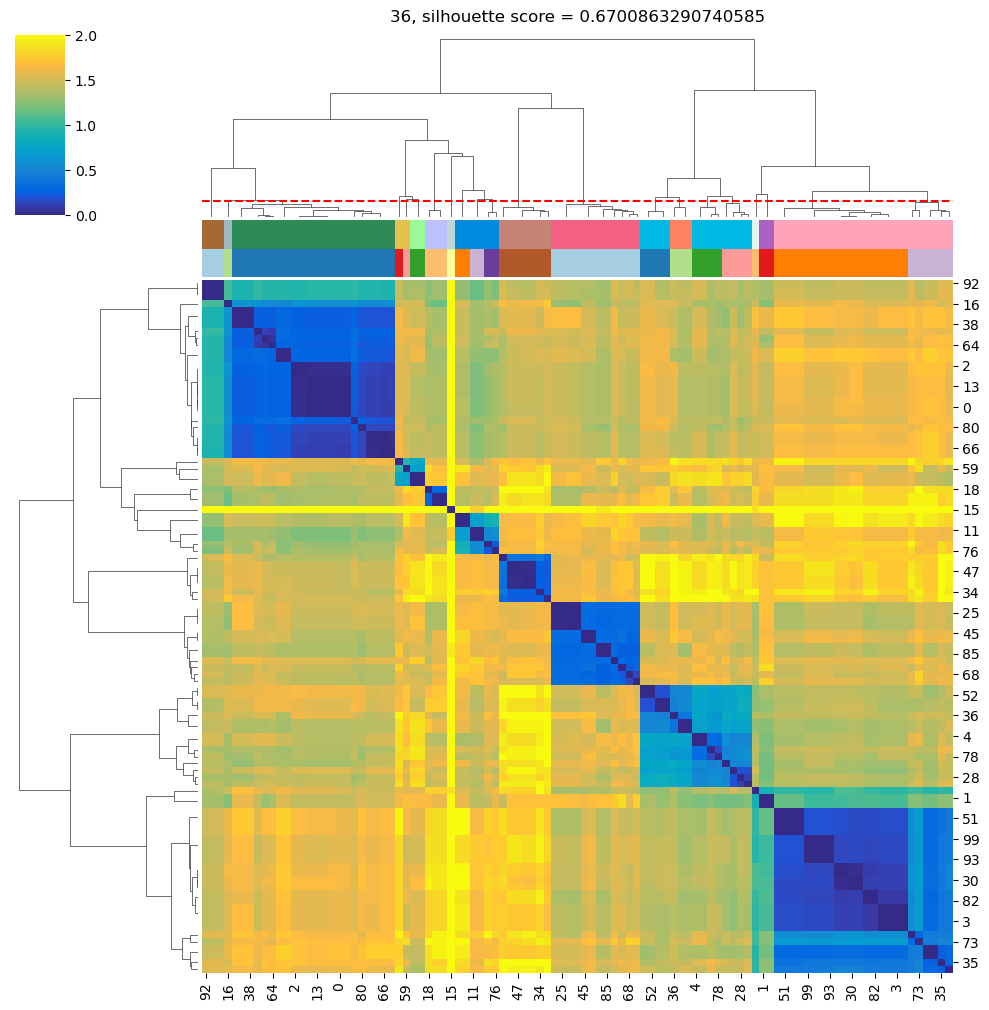

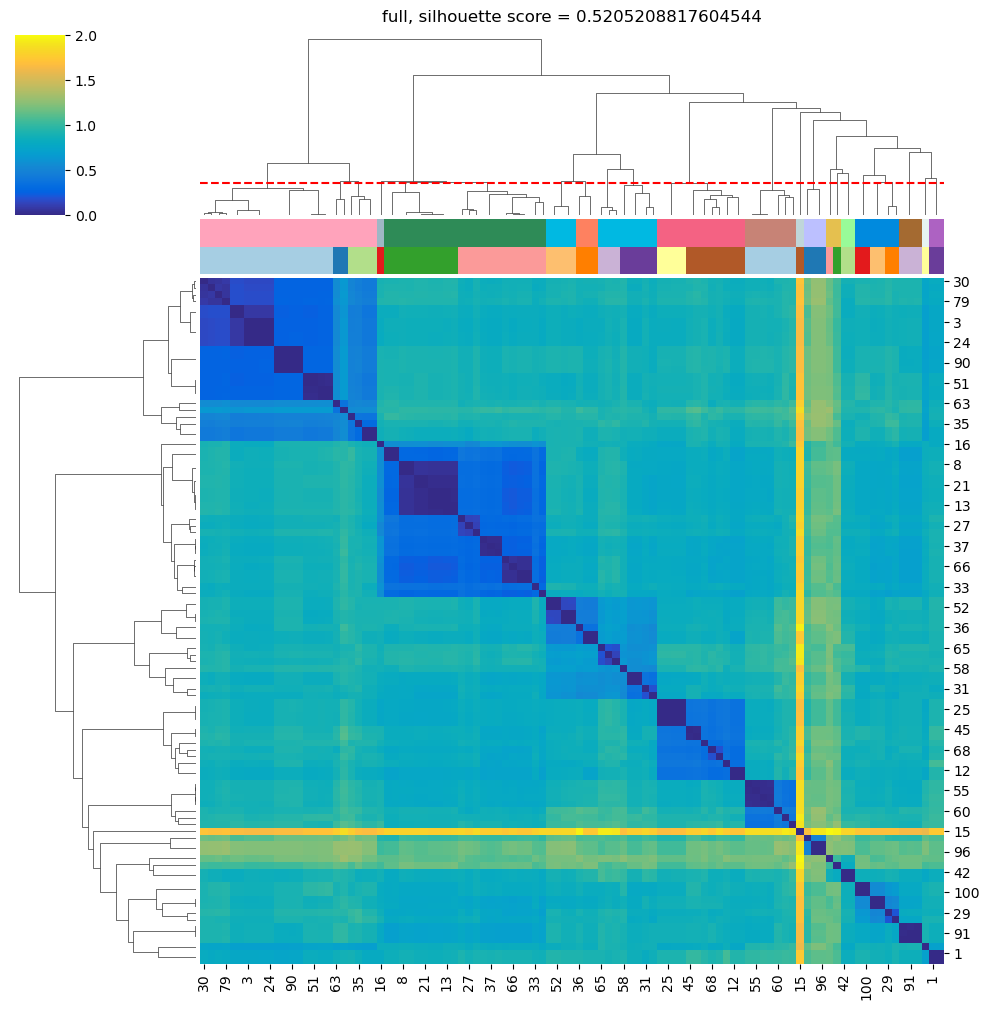

In [16]:
#explore parameters
Adomain_know_sub_aa_full = []
Adomain_know_sub_aa_36 = []
Adomain_know_sub_aa_45 = []
for index, row in A_substrates.iterrows():
	try:
		sp = sp_name_to_sp[row['spname']]
	except KeyError:
		sp = sp_name_to_sp_new[row['spname']]
	domain = row['Adomain']
	pos = sp.pyoverdine_domain[domain]
	pos_36 = pos[0] + np.array([sp.motif_dic[domain][3][1], sp.motif_dic[domain][6][0]])
	pos_45 = pos[0] + np.array([sp.motif_dic[domain][4][1], sp.motif_dic[domain][5][0]])
	if np.isnan(pos_36).any() or np.isnan(pos_45).any():
		continue
	
	aaseq = sp.pyoverdine_aa[int(pos[0]): int(pos[1])]
	aaseq.id = aaseq.id + '_' + domain
	Adomain_know_sub_aa_full.append(aaseq)

	aaseq_36 = sp.pyoverdine_aa[int(pos_36[0]): int(pos_36[1])]
	aaseq_36.id = aaseq_36.id + '_' + domain
	Adomain_know_sub_aa_36.append(aaseq_36)

	aaseq_45 = sp.pyoverdine_aa[int(pos_45[0]): int(pos_45[1])]
	aaseq_45.id = aaseq_45.id + '_' + domain
	Adomain_know_sub_aa_45.append(aaseq_45)

SeqIO.write(Adomain_know_sub_aa_full, "temp/Adomain_know_sub_aa_full.fasta", "fasta")
SeqIO.write(Adomain_know_sub_aa_36, "temp/Adomain_know_sub_aa_36.fasta", "fasta")
SeqIO.write(Adomain_know_sub_aa_45, "temp/Adomain_know_sub_aa_45.fasta", "fasta")

for fastafile in tqdm(glob.glob('temp/Adomain_know_sub_aa_*.fasta')):
	alnfile = fastafile.split('.')[0] + '.aln'
	subprocess.run(sub('clustalo -i {fastafile} -o {alnfile} --force'), shell=True)

#一组一个底物
par_combain = [
	['45', 'Jukes-Cantor', 'ward', 'distance', 0.7],
	['36', 'Jukes-Cantor', 'ward', 'distance', 0.7],
	['full', 'Jukes-Cantor', 'ward', 'distance', 0.7]]

i = 0
for feature, distance_method, linkage_method, cluster_method, threshold in par_combain:
	fasta_aa = [fasta for fasta in SeqIO.parse(sub("temp/Adomain_know_sub_aa_{feature}.aln"), "fasta")]
	distance_aa = pd.DataFrame(matlab_eng.seqpdist([str(fasta.seq) for fasta in fasta_aa],'SquareForm',True,'PairwiseAlignment',False,'UseParallel',True,'Method',distance_method))

	linkage_aa = hcluster.linkage(scipy.spatial.distance.squareform(distance_aa), method=linkage_method)
	clusters_aa = hcluster.fcluster(linkage_aa, threshold, cluster_method)

	aa_colormap = sns.color_palette("Paired", len(set(clusters_aa)))
	aa_clusters_colordict = dict(zip(set(clusters_aa),aa_colormap))
	aa_clusters_color = pd.Series([aa_clusters_colordict[group] for group in clusters_aa])

	silhouette_avg = silhouette_score(distance_aa, clusters_aa, metric = 'precomputed')

	cax = sns.clustermap(distance_aa, row_linkage=linkage_aa, col_linkage=linkage_aa, col_cluster=True, row_cluster=True, col_colors = [sub_color, aa_clusters_color], cmap=parula_map, vmin=0, vmax=2,)
	cax.ax_col_dendrogram.axes.set_title(sub('{feature}, silhouette score = {silhouette_avg}'))
	cax.ax_col_dendrogram.axes.axhline(threshold,color='r', linestyle = '--')


print(A_substrates['substrate'].unique())
colormap

In [17]:
#get A45 for prediction

Adomain_aa_45 = []
for sp in tqdm([sp for sp in suited_sp + New_sps]):
	for domain, pos in sp.pyoverdine_domain.items():
		if domain.split('_')[0] == 'A':
			pos_45 = pos[0] + np.array([sp.motif_dic[domain][4][1], sp.motif_dic[domain][5][0]])
			if np.isnan(pos_45[0]):
				pos_45[0] = pos_45[1] - 101
			if np.isnan(pos_45[1]):
				pos_45[1] = pos_45[0] + 101
			aaseq_45 = sp.pyoverdine_aa[int(pos_45[0]): int(pos_45[1])]
			aaseq_45.id = aaseq_45.id + '_' + domain
			Adomain_aa_45.append(aaseq_45)

SeqIO.write(Adomain_aa_45, "temp/Adomain_aa_45.fasta", "fasta")
subprocess.run(sub('clustalo -i temp/Adomain_aa_45.fasta -o temp/Adomain_aa_45.aln --force'), shell=True)
fasta_aa = [fasta for fasta in SeqIO.parse(sub("temp/Adomain_aa_45.aln"), "fasta")]
distance_aa = pd.DataFrame(matlab_eng.seqpdist([str(fasta.seq) for fasta in fasta_aa],'SquareForm',True,'PairwiseAlignment',False,'UseParallel',True,'Method','Jukes-Cantor'))

Adomain_know_sub_aa_45 = []
for index, row in A_substrates.iterrows():
	try:
		sp = sp_name_to_sp[row['spname']]
	except KeyError:
		sp = sp_name_to_sp_new[row['spname']]
	domain = row['Adomain']
	pos = sp.pyoverdine_domain[domain]
	pos_45 = pos[0] + np.array([sp.motif_dic[domain][4][1], sp.motif_dic[domain][5][0]])
	if np.isnan(pos_45[0]):
		pos_45[0] = pos_45[1] - 101
	aaseq_45 = sp.pyoverdine_aa[int(pos_45[0]): int(pos_45[1])]
	aaseq_45.id = aaseq_45.id + '_' + domain
	Adomain_know_sub_aa_45.append(aaseq_45)

SeqIO.write(Adomain_know_sub_aa_45, "temp/Adomain_know_sub_aa_45.fasta", "fasta")
subprocess.run(sub('clustalo -i temp/Adomain_know_sub_aa_45.fasta -o temp/Adomain_know_sub_aa_45.aln --force'), shell=True)

100%|██████████| 45/45 [00:00<00:00, 8331.22it/s]


CompletedProcess(args='clustalo -i temp/Adomain_know_sub_aa_45.fasta -o temp/Adomain_know_sub_aa_45.aln --force', returncode=0)

In [18]:
#prediction

feature, distance_method, linkage_method, cluster_method, threshold = ['45', 'Jukes-Cantor', 'ward', 'distance', 0.7]

#左侧轴不要参考
pyoverdine_idx = [i for i, fasta in enumerate(fasta_aa) if fasta.id.rsplit('_',2)[0] in pyoverdine_set]

linkage_aa = hcluster.linkage(scipy.spatial.distance.squareform(distance_aa.loc[pyoverdine_idx, pyoverdine_idx]), method=linkage_method)
clusters_aa = hcluster.fcluster(linkage_aa, threshold, cluster_method)

#对应Asub表格里的顺序
fasta_aa_know = [fasta for fasta in SeqIO.parse(sub("temp/Adomain_know_sub_aa_{feature}.aln"), "fasta")]
distance_aa_know = pd.DataFrame(matlab_eng.seqpdist([str(fasta.seq) for fasta in fasta_aa_know],'SquareForm',True,'PairwiseAlignment',False,'UseParallel',True,'Method',distance_method))
linkage_aa_know = hcluster.linkage(scipy.spatial.distance.squareform(distance_aa_know), method=linkage_method)
clusters_aa_know = hcluster.fcluster(linkage_aa_know, threshold, cluster_method)

A_substrates['domain_name'] = A_substrates['spname'] + '_' + A_substrates['Adomain']
A_substrates['clustr'] = clusters_aa_know
know_sub_A = A_substrates['domain_name'].tolist()
know_sub = [A_substrates[A_substrates['domain_name'] == fasta.id]['substrate'].iloc[0] for fasta in fasta_aa if fasta.id in know_sub_A]
know_clu = [A_substrates[A_substrates['domain_name'] == fasta.id]['clustr'].iloc[0] for fasta in fasta_aa if fasta.id in know_sub_A]

#和所有参考的距离矩阵
know_idx = [i for i, fasta in enumerate(fasta_aa) if fasta.id in know_sub_A]
draw_matrix = distance_aa.loc[pyoverdine_idx,know_idx]

distance_know = distance_aa.loc[know_idx,know_idx]
linkage_know = hcluster.linkage(scipy.spatial.distance.squareform(distance_know), method=linkage_method)

#全部组别颜色
aa_colormap = sns.color_palette("Paired", len(set(clusters_aa)))
aa_clusters_colordict = dict(zip(set(clusters_aa),aa_colormap))
aa_clusters_color = pd.Series([aa_clusters_colordict[group] for group in clusters_aa])

#ref组别颜色
aa_colormap_know = sns.color_palette("tab10", len(set(know_clu)))
aa_clusters_colordict_know = dict(zip(set(know_clu),aa_colormap_know))
aa_clusters_color_know = pd.Series([aa_clusters_colordict_know[group] for group in know_clu])

sub_color = pd.Series([sub_colordict[group] for group in know_sub])


##################################################
##################################################
def with_E(domainid):
	spname = domainid.rsplit('_',2)[0]
	domain_num = domainid.rsplit('_',2)[2]
	if 'E_' + domain_num in sp_name_to_sp[spname].pyoverdine_domain:
		return('+')
	else:
		return('-')

ref_A = pd.DataFrame(np.array([know_idx, know_sub, know_clu]).T, columns=['domainid', 'know_sub', 'know_clu']).set_index('domainid')
domains = []
closest_clu = []
indecate_sub = []
second_sub = []
E_domain = []
digital = []
for index, row in tqdm(draw_matrix.iterrows()):
	domainid = fasta_aa[index].id
	spname = domainid.rsplit('_',2)[0]
	if spname in pyoverdine_set:
		domains.append(domainid)
		E_domain.append(with_E(domainid))

		df = ref_A.copy()
		df['distance'] = row.tolist()
		#0.5192 = 60%identity remind
		#0.9486 = 40%identity
		#0.7 = 50%identity 出现杂条
		#可信的范围
		df = df[df.distance < 0.7]
		#有相近的
		if len(df):
			df = pd.DataFrame([df[df.know_clu == idx].min() for idx in df.value_counts('know_clu').index])
			df = df.sort_values(by='distance')
			minimal_1 = df['distance'].iloc[0]
			try:
				minimal_2 = df['distance'].iloc[1]
			except:
				minimal_2 = 1.5
			#两个ref都挺近的
			if (minimal_2 - minimal_1)/(minimal_1+0.0001) < 0.2:
				#将相同底物按照顺序
				df = df.iloc[[0,1]].sort_values(by = 'know_sub')
				closest_clu.append(df['know_clu'].iloc[0])
				indecate_sub.append(df['know_sub'].iloc[0])
				second_sub.append(df['know_sub'].iloc[1])
			else:
				closest_clu.append(df['know_clu'].iloc[0])
				indecate_sub.append(df['know_sub'].iloc[0])
				second_sub.append(df['know_sub'].iloc[0])
		else:
			closest_clu.append('Unknow')
			indecate_sub.append('Unknow')
			second_sub.append('Unknow')
		#写成digital
		if indecate_sub[-1] == second_sub[-1]:
			digital.append(E_domain[-1] + indecate_sub[-1])
		else:
			digital.append(E_domain[-1] + indecate_sub[-1] + '/' + E_domain[-1] + second_sub[-1])

out_df = pd.DataFrame(np.array([domains, closest_clu, indecate_sub, second_sub, E_domain, digital]).T, columns=['domainid', 'closest_clu', 'indecate_sub', 'second_sub', 'with_E', 'digital'])

out_df = out_df.set_index('domainid')

digital_df = pd.DataFrame(columns=['spname', 'digital_A'])
for sp in [sp_name_to_sp[spname] for spname in pyoverdine_set]:
	digital = []
	for domain in sp.pyoverdine_domain:
		if domain.split('_')[0] == 'A':
			Adomainid = sp.name + '_' + domain
			if Adomainid in out_df.index:
				dig = out_df.loc[Adomainid, 'digital']
				digital.append(dig)
			else:
				out_df.loc[Adomainid] = ['No_motif', 'No_motif', 'No_motif', with_E(Adomainid), with_E(Adomainid) + 'No_motif']
				digital.append(with_E(Adomainid) + 'No_motif')
	digital_df.loc[len(digital_df)] = [sp.name, digital]

out_df.to_excel('All_Adomain_indecate.xlsx')
digital_df.to_excel('pyoverdine_digital.xlsx')

0it [00:00, ?it/s]

304it [00:00, 498.51it/s]


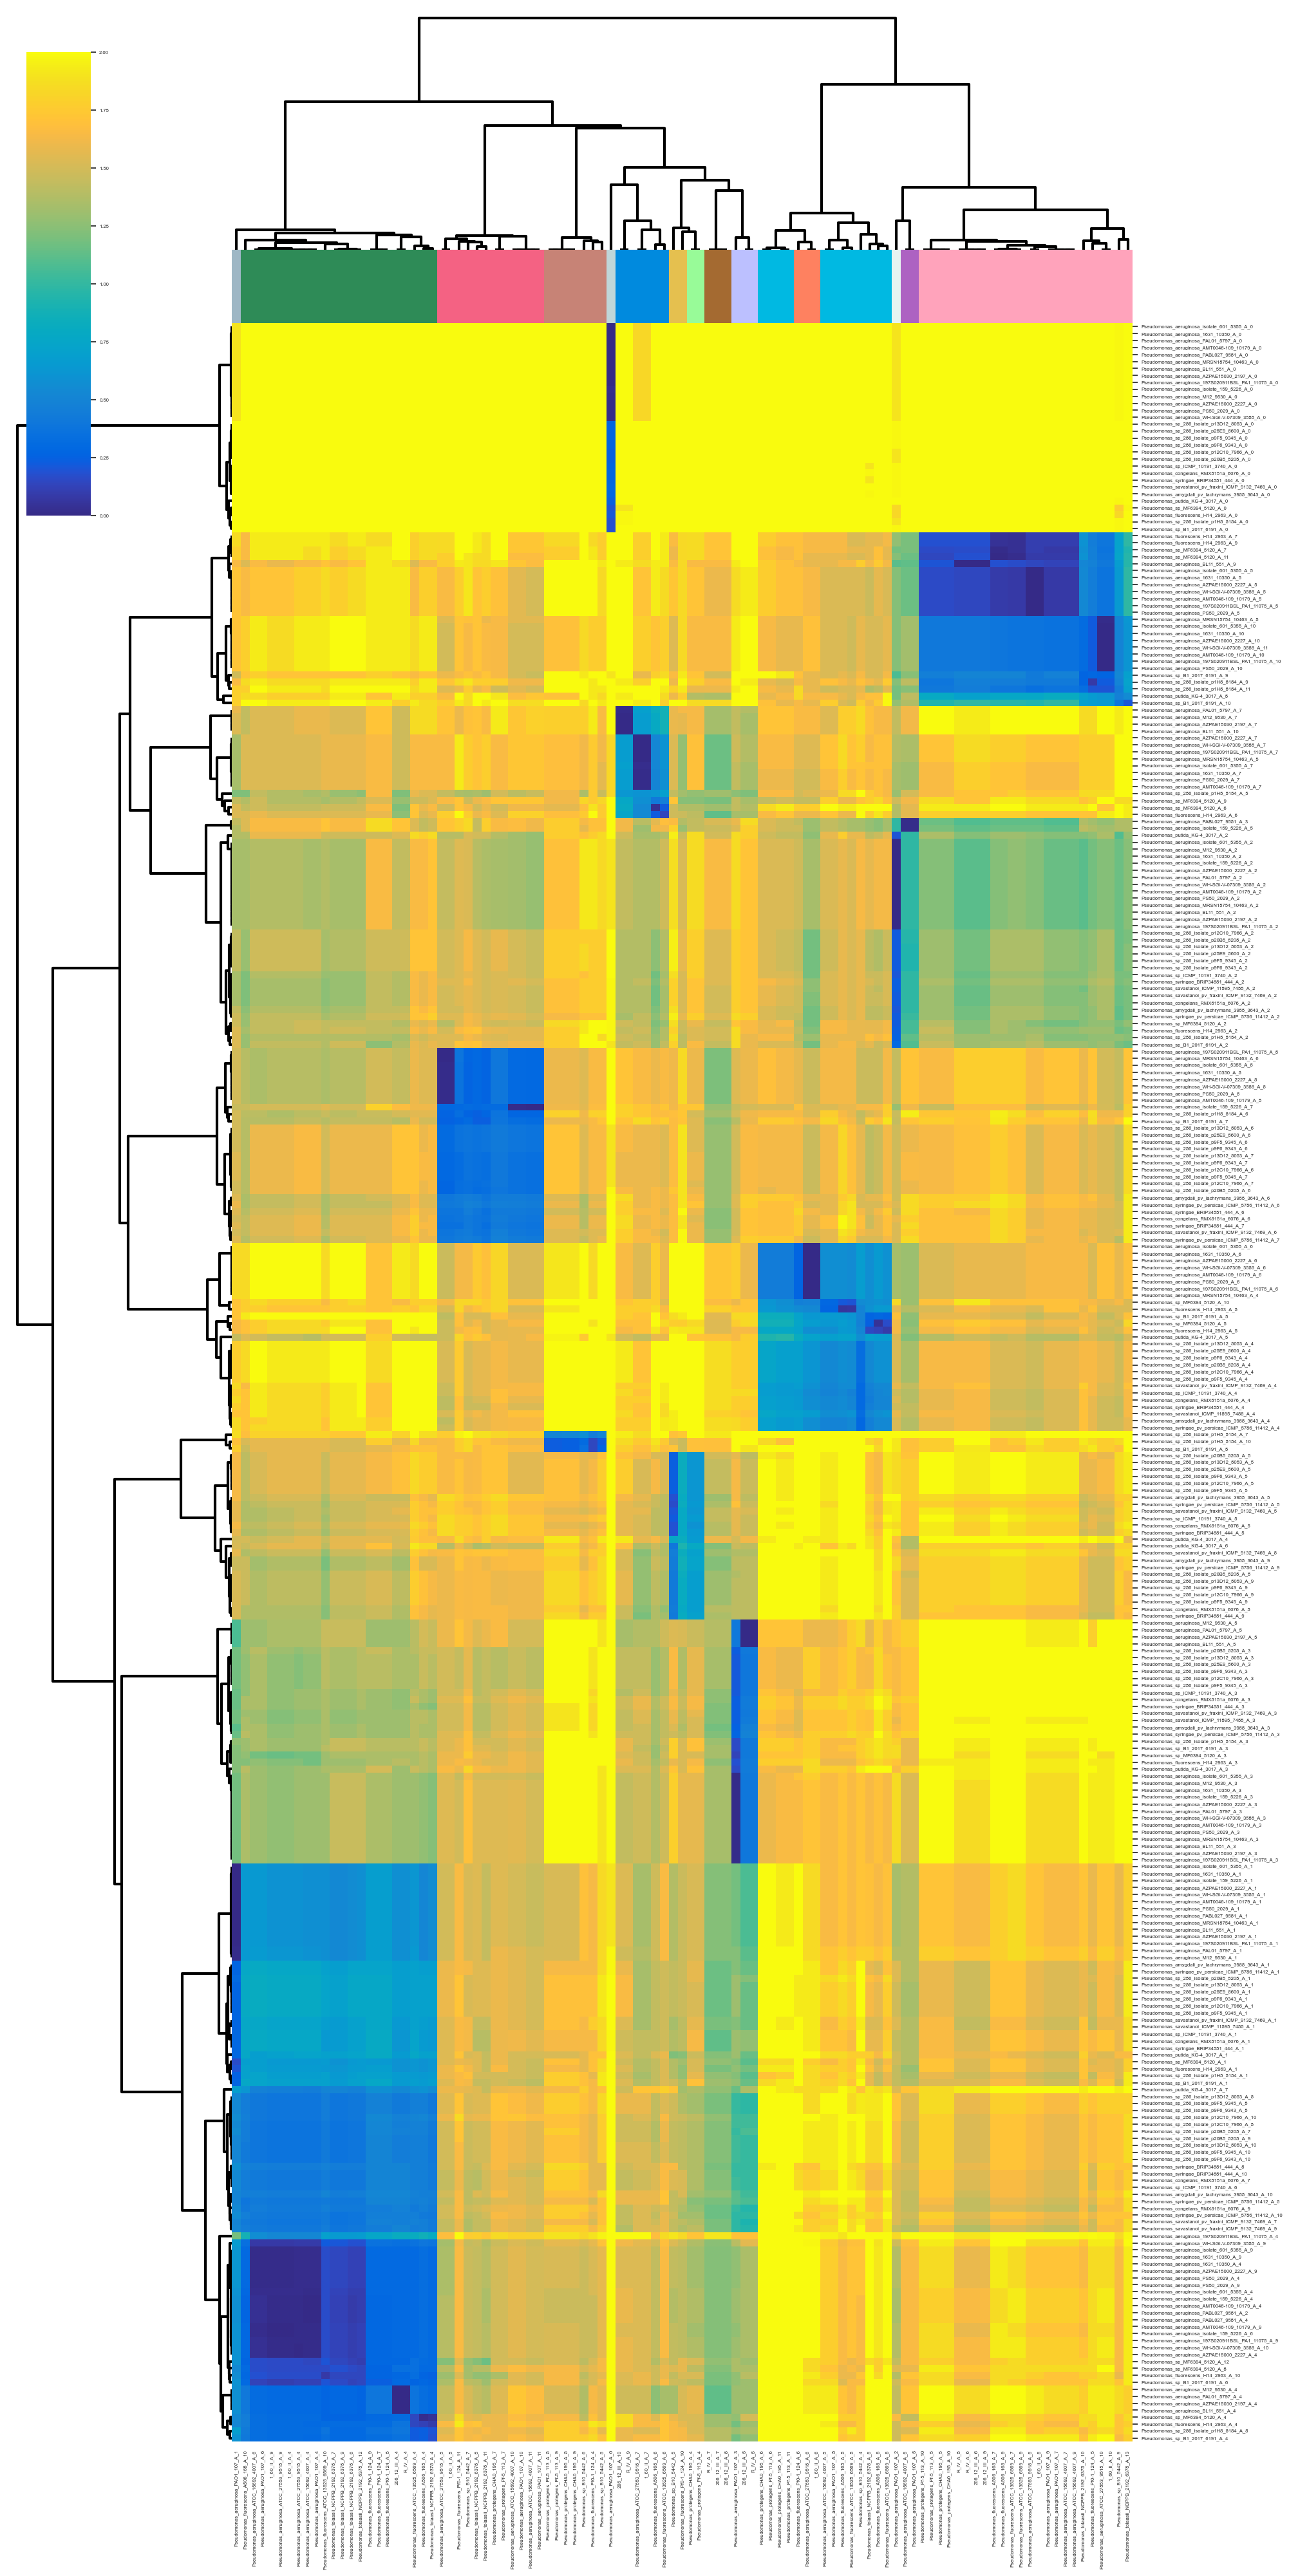

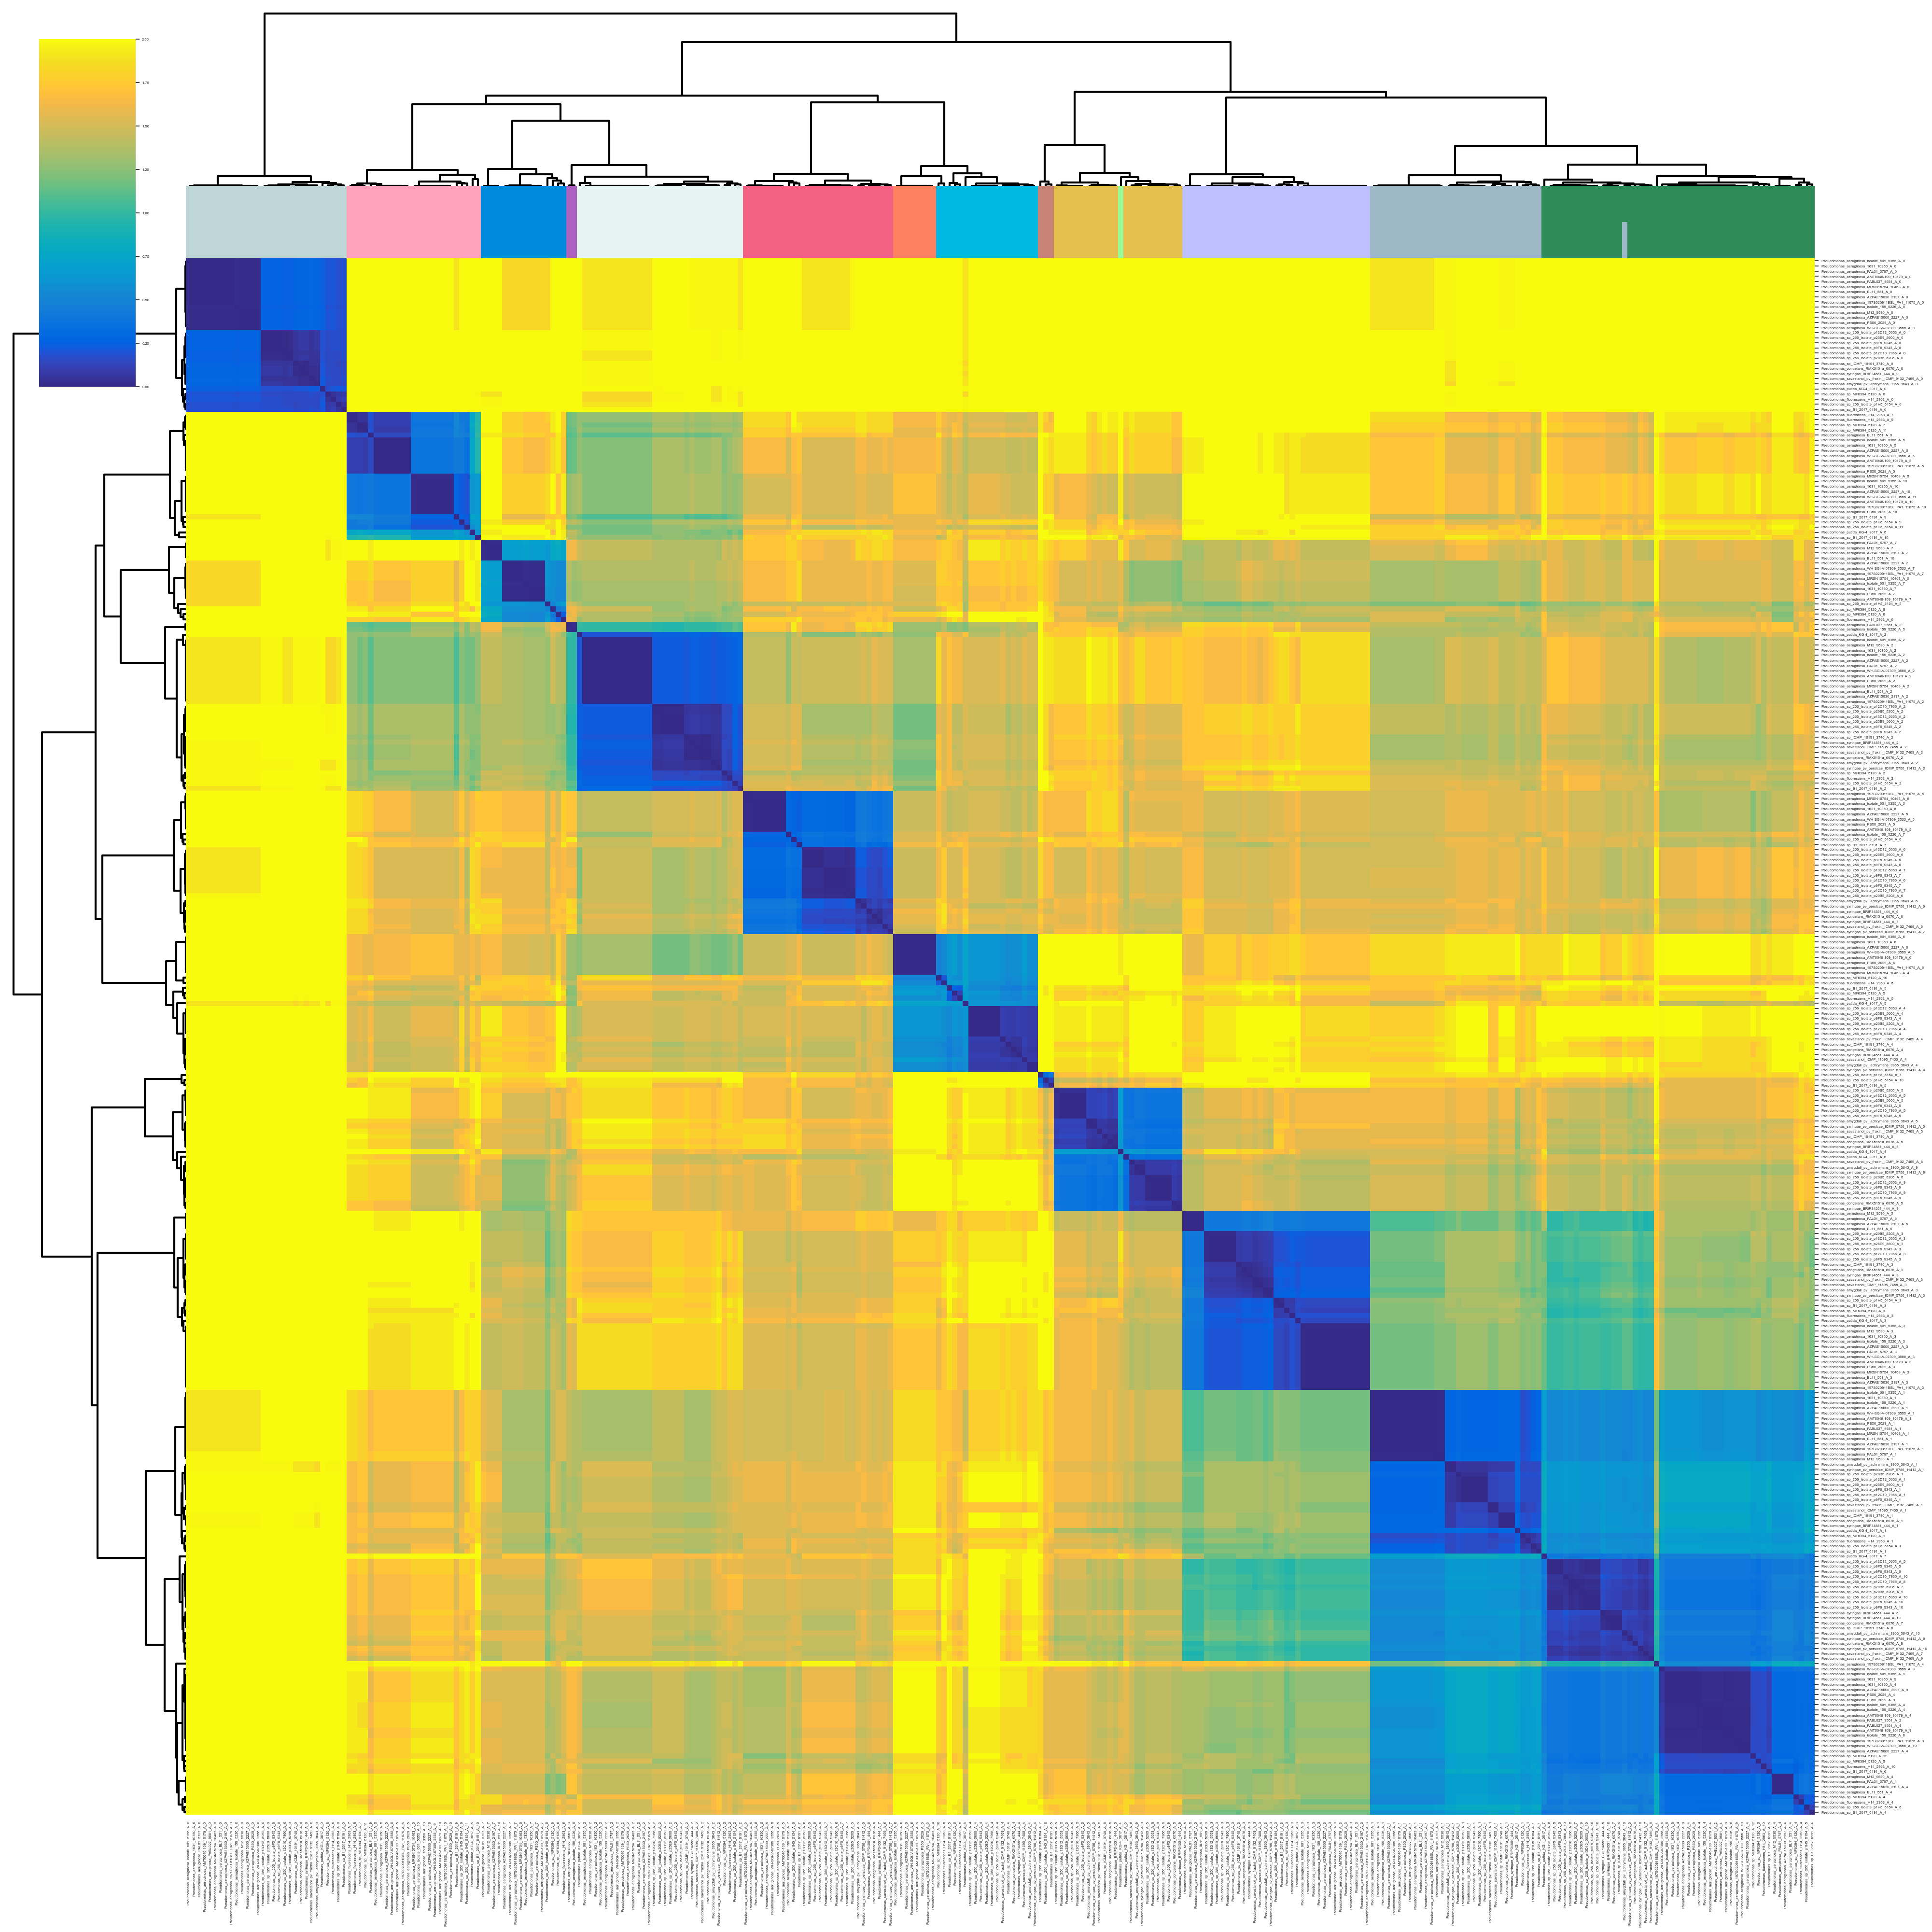

In [19]:
#visualize distanced matrix

sns.set(font_scale = 0.5)
pyoverdine_name = [fasta.id for i, fasta in enumerate(fasta_aa) if fasta.id.rsplit('_',2)[0] in pyoverdine_set]
know_name = [fasta.id for i, fasta in enumerate(fasta_aa) if fasta.id in know_sub_A]

cax = sns.clustermap(draw_matrix, figsize=(20, 40), dendrogram_ratio=(0.2,0.1), colors_ratio=(0.03,0.03), row_linkage=linkage_aa, col_linkage=linkage_know, col_cluster=True, row_cluster=True, col_colors = [sub_color], cmap=parula_map, vmin=0, vmax=2, cbar_kws={}, xticklabels=know_name, yticklabels=pyoverdine_name, tree_kws=dict(linewidths=3, colors=(0, 0, 0)))

sub_colordict['Unknow'] = 'grey'
indecate_sub = []
for seq in fasta_aa:
	Adomainid = seq.id
	if Adomainid in out_df.index:
		indecate_sub.append(out_df.loc[Adomainid, 'indecate_sub'])
indecate_sub_color = pd.Series([sub_colordict[group] for group in indecate_sub])
second_sub_color = pd.Series([sub_colordict[group] for group in second_sub])

cax = sns.clustermap(distance_aa.loc[pyoverdine_idx,pyoverdine_idx], figsize=(40, 40), dendrogram_ratio=(0.1,0.1), colors_ratio=(0.03,0.02), row_linkage=linkage_aa, col_linkage=linkage_aa, col_cluster=True, row_cluster=True, col_colors = [second_sub_color, indecate_sub_color], cmap=parula_map, vmin=0, vmax=2, cbar_kws={}, xticklabels=pyoverdine_name, yticklabels=pyoverdine_name,tree_kws=dict(linewidths=3, colors=(0, 0, 0)))
